Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9997756..0.999914].


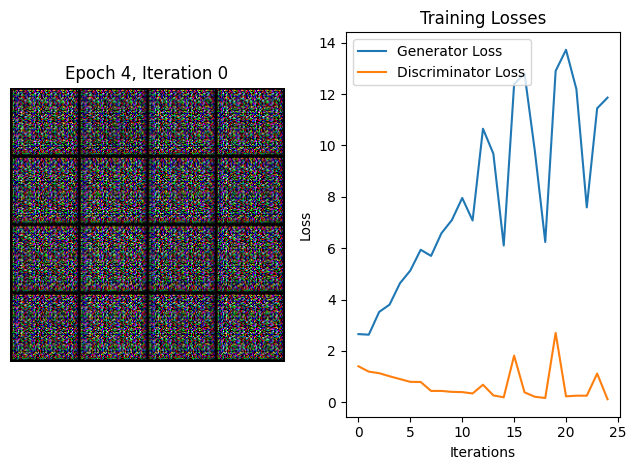

 62%|██████▎   | 5/8 [00:02<00:01,  2.01it/s]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
latent_dim = 100
img_size = 64
channels = 3
batch_size = 64
epochs = 200
lr = 0.0002
beta1 = 0.5

# Set up data loading
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='D:\\Diffusion\\Training\\_datasets\\dreamweaver\\dreamweaver_cont\\backbend-chest-side', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
g_losses = []
d_losses = []

# Set up the plot
plt.figure(figsize=(20, 10))
plt.ion()

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(dataloader)):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(batch_size).to(device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(batch_size).to(device)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        output = discriminator(fake_images)
        g_loss = criterion(output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()

        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        # Visualize results every 50 iterations
        if i % 50 == 0:
            clear_output(wait=True)
            plt.clf()

            # Generate and visualize fake images
            with torch.no_grad():
                fake_images = generator(torch.randn(16, latent_dim, 1, 1).to(device)).cpu()
                grid = make_grid(fake_images, nrow=4, normalize=True)
                
                plt.subplot(1, 2, 1)
                plt.imshow(grid.permute(1, 2, 0))
                plt.axis('off')
                plt.title(f"Epoch {epoch+1}, Iteration {i}")

            # Plot loss curves
            plt.subplot(1, 2, 2)
            plt.plot(g_losses, label='Generator Loss')
            plt.plot(d_losses, label='Discriminator Loss')
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training Losses')

            plt.tight_layout()
            plt.show()
            #plt.pause(0.1)

    #print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

plt.ioff()
plt.show()